In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
from datasets import load_dataset

# Load the HF dataset in streaming mode to avoid full download
dataset = load_dataset(
    "philschmid/amazon-product-descriptions-vlm",
    split="train",
    streaming=True
)

# Deterministic stream split using the index modulo trick
# (keeps memory low and avoids needing a materialized dataset)
def train_test_split_stream(dataset, test_ratio=0.1):
    train_ds = dataset.filter(lambda _, idx: idx % int(1/test_ratio) != 0, with_indices=True)
    test_ds  = dataset.filter(lambda _, idx: idx % int(1/test_ratio) == 0, with_indices=True)
    return train_ds, test_ds

train_dataset, test_dataset = train_test_split_stream(dataset, test_ratio=0.1)

In [42]:
from PIL import Image
import io

# Normalize image field into a PIL RGB image for downstream transforms
def decode_image(example):
    img = example["image"]

    # Case 1: already decoded (PIL Image)
    if isinstance(img, Image.Image):
        example["image"] = img.convert("RGB")
        return example

    # Case 2: raw bytes dict
    if isinstance(img, dict) and "bytes" in img:
        example["image"] = Image.open(
            io.BytesIO(img["bytes"])
        ).convert("RGB")
        return example

    raise TypeError(f"Unexpected image type: {type(img)}")


# Apply decode to streamed train/test splits
train_dataset = train_dataset.map(decode_image)
test_dataset  = test_dataset.map(decode_image)

In [43]:
dataset

IterableDataset({
    features: ['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description'],
    num_shards: 1
})

In [44]:
for sample in dataset.take(1):
    img = sample["image"]
    print("Type:", type(img))
    print("Mode:", img.mode)
    print(img.size if hasattr(img, "size") else img)

Type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Mode: RGB
(500, 500)


In [45]:
train_sample = next(iter(train_dataset))["image"]
test_sample  = next(iter(test_dataset))["image"]

print(train_sample)
print("Train image type:", type(train_sample))

print(test_sample)
print("Test image type:", type(test_sample))

<PIL.Image.Image image mode=RGB size=338x500 at 0x7B901D905CA0>
Train image type: <class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=500x500 at 0x7B9018F13FE0>
Test image type: <class 'PIL.Image.Image'>


In [46]:
sample = next(iter(train_dataset))
img = next(iter(train_dataset))["image"]

print("Type:", type(img))
print("PIL size (W, H):", img.size)
print("Mode:", img.mode)

Type: <class 'PIL.Image.Image'>
PIL size (W, H): (338, 500)
Mode: RGB


In [47]:
import os
import math
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, AutoImageProcessor

# Model/checkpoint names and basic shapes
TEXT_MODEL = "bert-base-uncased"
VIT_MODEL = "google/vit-base-patch16-224"
MAX_LENGTH = 128
BATCH_SIZE = 4

# Dataset-specific fields for text and price
TEXT_FIELDS = [
    "Product Name",
    "Uniq Id",
]
PRICE_FIELDS = [
    "Selling Price",
]

tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
image_processor = AutoImageProcessor.from_pretrained(VIT_MODEL)

# Resolve target image size from the processor metadata
if isinstance(image_processor.size, dict):
    IMAGE_SIZE = image_processor.size.get("height", 224)
else:
    IMAGE_SIZE = image_processor.size


def build_text(example):
    # Concatenate available text fields into one string
    parts = [example.get(f) for f in TEXT_FIELDS if f in example and example.get(f)]
    return " ".join([str(p) for p in parts if p]).strip()


def parse_price(val):
    # Robust price parsing supporting numeric and string inputs
    if val is None:
        return None
    if isinstance(val, (int, float)):
        return float(val)
    if isinstance(val, str):
        cleaned = val.replace("$", "").replace(",", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None


def get_price(example):
    # Pick the first price field that parses correctly
    for f in PRICE_FIELDS:
        if f in example:
            price = parse_price(example[f])
            if price is not None:
                return price
    raise KeyError("No price field found in example")


def preprocess_example(example):
    # Decode image to RGB PIL
    img = example["image"]
    if isinstance(img, dict) and "bytes" in img:
        img = Image.open(io.BytesIO(img["bytes"])).convert("RGB")
    elif isinstance(img, Image.Image):
        img = img.convert("RGB")
    else:
        raise TypeError(f"Unexpected image type: {type(img)}")

    # Build text and numeric target (log price)
    text = build_text(example)
    price = max(get_price(example), 1e-3)
    log_price = float(math.log(price))

    # Tokenize text and process image to ViT format (channels_last)
    text_inputs = tokenizer(
        text if text else "",
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="np",
    )
    image_inputs = image_processor(images=img, return_tensors="np", data_format="channels_last")

    return {
        "input_ids": text_inputs["input_ids"][0].astype(np.int32),
        "attention_mask": text_inputs["attention_mask"][0].astype(np.int32),
        "pixel_values": image_inputs["pixel_values"][0].astype(np.float32),  # (H, W, 3)
        "labels": np.array(log_price, dtype=np.float32),
    }



Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [48]:
# Bucketized price counts per $100 (before price range filtering)
import numpy as np
from collections import Counter

# Filter out examples lacking a parseable price to avoid KeyError
raw_filtered = train_dataset.filter(
    lambda ex: any(parse_price(ex.get(f)) is not None for f in PRICE_FIELDS)
)
raw_processed_train = raw_filtered.map(preprocess_example)

price_samples_raw = []
MAX_SAMPLES_RAW = 1000  # adjust for more coverage
for ex in raw_processed_train.take(MAX_SAMPLES_RAW):
    try:
        price_samples_raw.append(float(np.exp(ex["labels"])))  # labels are log-price
    except Exception:
        continue

bucket_counts_raw = Counter()
for p in price_samples_raw:
    bin_floor = int(p // 100) * 100
    bin_label = f"{bin_floor}-{bin_floor+100}"
    bucket_counts_raw[bin_label] += 1

sorted_bins_raw = sorted(bucket_counts_raw.items(), key=lambda kv: int(kv[0].split('-')[0]))
print("Price bucket counts before filtering (width=$100):")
for label, cnt in sorted_bins_raw:
    print(f"{label}: {cnt}")


Price bucket counts before filtering (width=$100):
0-100: 940
100-200: 38
200-300: 6
300-400: 5
400-500: 3
500-600: 2
900-1000: 1
1300-1400: 1
1700-1800: 1
2800-2900: 1
4100-4200: 1
5300-5400: 1


dict_keys(['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description', 'input_ids', 'attention_mask', 'pixel_values', 'labels'])
input_ids shape: (128,)
pixel_values shape: (224, 224, 3)
label: 5.1647286


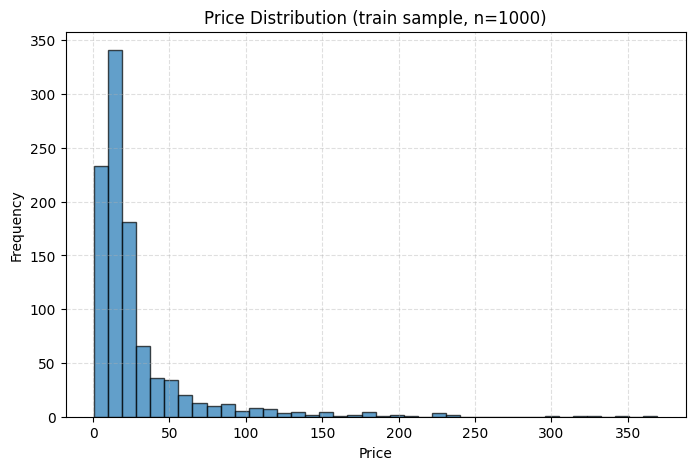

Price bucket counts (width=$100):
0-100: 950
100-200: 39
200-300: 6
300-400: 5


In [49]:
# Price filtering, preprocessing, histogram, and bucket counts (run after definitions above)
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

MIN_PRICE = 1.0
MAX_TRAIN_PRICE = 400.0


def has_price_field(example):
    # keep only if a price is parseable and within (0, MAX_TRAIN_PRICE]
    for f in PRICE_FIELDS:
        val = parse_price(example.get(f))
        if val is not None and 0 < val <= MAX_TRAIN_PRICE:
            return True
    return False

# Filter datasets by price bounds
train_dataset = train_dataset.filter(has_price_field)
test_dataset = test_dataset.filter(has_price_field)

# Streamed preprocessing for train/test
processed_train = train_dataset.map(preprocess_example)
processed_test = test_dataset.map(preprocess_example)

# Quick sanity check on shapes
for sample in processed_train.take(1):
    print(sample.keys())
    print("input_ids shape:", np.array(sample["input_ids"]).shape)
    print("pixel_values shape:", np.array(sample["pixel_values"]).shape)
    print("label:", sample["labels"])

# Histogram of prices (unlogged)
price_samples = []
MAX_SAMPLES = 1000  # increase if you want more coverage
for ex in processed_train.take(MAX_SAMPLES):
    try:
        price_samples.append(float(np.exp(ex["labels"])))  # labels are log-price
    except Exception:
        continue

plt.figure(figsize=(8, 5))
plt.hist(price_samples, bins=40, alpha=0.7, color="tab:blue", edgecolor="black")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title(f"Price Distribution (train sample, n={len(price_samples)})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Bucketized price counts per $100 range
bucket_counts = Counter()
for p in price_samples:
    bin_floor = int(p // 100) * 100
    bin_label = f"{bin_floor}-{bin_floor+100}"
    bucket_counts[bin_label] += 1

sorted_bins = sorted(bucket_counts.items(), key=lambda kv: int(kv[0].split('-')[0]))
print("Price bucket counts (width=$100):")
for label, cnt in sorted_bins:
    print(f"{label}: {cnt}")


In [50]:
import tensorflow as tf, keras, datasets
from datasets import config as ds_config

print("tf", tf.__version__, "keras", keras.__version__)
print("datasets", datasets.__version__)
print("tf available?", ds_config.TF_AVAILABLE)

tf 2.19.0 keras 3.10.0
datasets 4.0.0
tf available? True


In [51]:
# Convert IterableDataset to tf.data.Dataset
columns = ["input_ids", "attention_mask", "pixel_values"]


def gen_tf(ds):
    # Wrap the streaming HF iterable and yield tensors for TF
    for ex in ds:
        features = {k: tf.convert_to_tensor(ex[k]) for k in columns}
        label = tf.convert_to_tensor(ex["labels"], dtype=tf.float32)
        yield features, label

# Explicit output signature to keep shapes/dtypes static for TF
audio_shape = tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32)
output_signature = (
    {
        "input_ids": audio_shape,
        "attention_mask": audio_shape,
        "pixel_values": tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(), dtype=tf.float32),
)

# Build batched datasets for train/test
train_tf = tf.data.Dataset.from_generator(
    lambda: gen_tf(processed_train), output_signature=output_signature
).batch(BATCH_SIZE)

test_tf = tf.data.Dataset.from_generator(
    lambda: gen_tf(processed_test), output_signature=output_signature
).batch(BATCH_SIZE)

# Sanity check of the first batch
for batch in train_tf.take(1):
    x, y = batch
    print({k: v.shape for k, v in x.items()})
    print("labels shape:", y.shape)


{'input_ids': TensorShape([4, 128]), 'attention_mask': TensorShape([4, 128]), 'pixel_values': TensorShape([4, 224, 224, 3])}
labels shape: (4,)


In [52]:
from transformers import TFBertModel, TFViTModel

from transformers import AutoTokenizer, AutoImageProcessor
from transformers import TFBertModel, TFViTModel

# TEXT_MODEL = "bert-base-uncased"
# VIT_MODEL  = "google/vit-base-patch16-224"

tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
image_processor = AutoImageProcessor.from_pretrained(VIT_MODEL)

bert_encoder = TFBertModel.from_pretrained(
    TEXT_MODEL,
    from_pt=True,            # convert from PyTorch weights
    use_safetensors=False    # avoid safe_open bug
)
bert_encoder.trainable = False

vit_encoder = TFViTModel.from_pretrained(
    VIT_MODEL,
    from_pt=True,
    use_safetensors=False
)
vit_encoder.trainable = False # Corrected typo: vt_encoder to vit_encoder

input_ids = tf.keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask")

# Define pixel_values input in channels-last format to match the image_processor and tf.data.Dataset
pixel_values_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32, name="pixel_values")

# Transpose pixel_values_input from channels-last (H, W, C) to channels-first (C, H, W) for ViT
transposed_pixel_values = tf.transpose(pixel_values_input, perm=[0, 3, 1, 2])

bert_outputs = bert_encoder(
    input_ids=input_ids,
    attention_mask=attention_mask,
    training=False,
)
vit_outputs = vit_encoder(transposed_pixel_values, training=False) # Pass transposed_pixel_values

cls_text = bert_outputs.pooler_output
cls_image = vit_outputs.pooler_output

x = tf.keras.layers.Concatenate(name="concat_cls")([cls_text, cls_image])
x = tf.keras.layers.Dense(256, activation="relu", name="dense1")(x)
x = tf.keras.layers.Dropout(0.1)(x)
log_price = tf.keras.layers.Dense(1, name="log_price")(x)

model = tf.keras.Model(
    inputs={"input_ids": input_ids, "attention_mask": attention_mask, "pixel_values": pixel_values_input},
    outputs=log_price,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="mse",
    metrics=["mae"],
)

model.summary()


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceCl

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pixel_values (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf.compat.v1.transpose_1 (  (None, 3, 224, 224)          0         ['pixel_values[0][0]']  

In [53]:
EPOCHS = 10  # adjust based on resources

# Train only the regression head (encoders are frozen)
history = model.fit(
    train_tf,
    validation_data=test_tf,
    epochs=EPOCHS,
)

# Quick prediction sanity check on one batch
for batch in test_tf.take(1):
    preds_log = model.predict(batch[0])
    preds_price = np.exp(preds_log)
    print("Pred price (first 5, unlogged):", preds_price[:5].ravel())
    break

Epoch 1/10
287/287 [==============================] - 45s 81ms/step - loss: 1.0110 - mae: 0.7630 - val_loss: 0.6887 - val_mae: 0.6645
Epoch 2/10
287/287 [==============================] - 19s 55ms/step - loss: 0.6133 - mae: 0.6124 - val_loss: 0.6321 - val_mae: 0.6366
Epoch 3/10
287/287 [==============================] - 17s 54ms/step - loss: 0.5016 - mae: 0.5538 - val_loss: 0.6541 - val_mae: 0.6486
Epoch 4/10
287/287 [==============================] - 19s 55ms/step - loss: 0.4477 - mae: 0.5179 - val_loss: 0.6777 - val_mae: 0.6604
Epoch 5/10
287/287 [==============================] - 19s 60ms/step - loss: 0.4021 - mae: 0.4982 - val_loss: 0.7313 - val_mae: 0.6813
Epoch 6/10
287/287 [==============================] - 16s 52ms/step - loss: 0.3615 - mae: 0.4788 - val_loss: 0.7451 - val_mae: 0.6793
Epoch 7/10
287/287 [==============================] - 19s 58ms/step - loss: 0.3043 - mae: 0.4349 - val_loss: 0.7590 - val_mae: 0.6890
Epoch 8/10
287/287 [==============================] - 19s 52ms

In [54]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Evaluate regression metrics on the test set (log targets)
eval_results = model.evaluate(test_tf, return_dict=True, verbose=0)
rmse = float(np.sqrt(eval_results["loss"]))
mae_log = float(eval_results["mae"])

# Compute R² and MAPE by iterating over the TF dataset
# (predictions are in log-space; MAPE will be on log target, which is approximate)
y_true_log = np.concatenate([y.numpy() for _, y in test_tf])
y_pred_log = np.concatenate([model.predict(x, verbose=0).flatten() for x, _ in test_tf])

r2 = r2_score(y_true_log, y_pred_log)
mape = mean_absolute_percentage_error(y_true_log, y_pred_log)

print({
    "mse": eval_results["loss"],
    "rmse": rmse,
    "mae_log": mae_log,
    "r2": r2,
    "mape": mape,
})

{'mse': 0.8500022292137146, 'rmse': 0.9219556546893752, 'mae_log': 0.732970118522644, 'r2': -0.2874155044555664, 'mape': 0.2830866575241089}


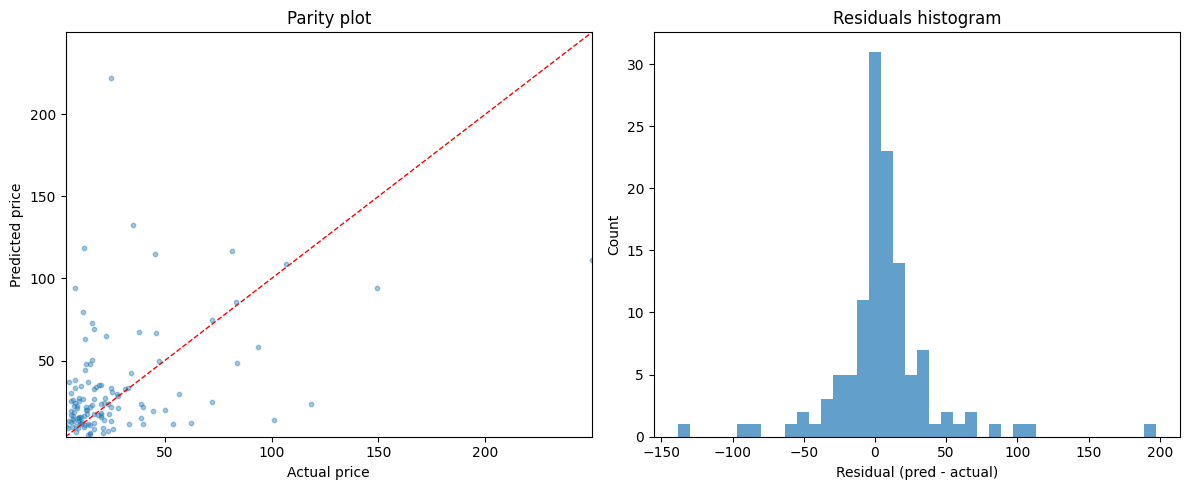

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Collect predictions and labels (log-scale) from test_tf
y_true_log, y_pred_log = [], []
for x_batch, y_batch in test_tf:
    preds = model.predict(x_batch, verbose=0).flatten()
    y_true_log.append(y_batch.numpy())
    y_pred_log.append(preds)

y_true_log = np.concatenate(y_true_log)
y_pred_log = np.concatenate(y_pred_log)

# Convert to price scale for more interpretable plots
y_true = np.exp(y_true_log)
y_pred = np.exp(y_pred_log)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Parity plot (ideal: points along the diagonal)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=10)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
axes[0].plot(lims, lims, 'r--', lw=1)
axes[0].set_xlim(lims); axes[0].set_ylim(lims)
axes[0].set_xlabel("Actual price"); axes[0].set_ylabel("Predicted price")
axes[0].set_title("Parity plot")

# Residuals in price space
residuals = y_pred - y_true
axes[1].hist(residuals, bins=40, alpha=0.7)
axes[1].set_xlabel("Residual (pred - actual)"); axes[1].set_ylabel("Count")
axes[1].set_title("Residuals histogram")

plt.tight_layout()
plt.show()

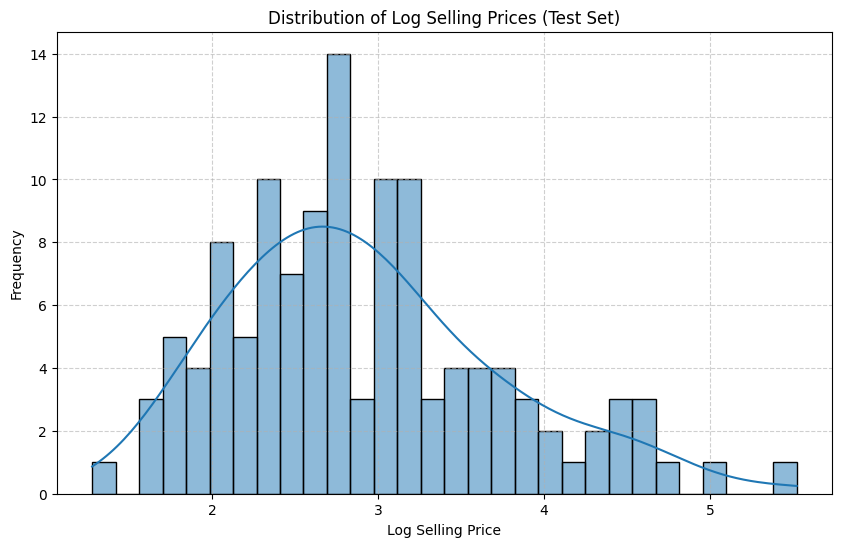

In [56]:
# Get log prices from the test dataset for plotting
# We'll take a reasonable number of samples to avoid excessive computation if the dataset is very large
sample_log_prices = []
num_samples_to_plot = 1000 # Adjust as needed

for i, sample in enumerate(processed_test.take(num_samples_to_plot)):
    sample_log_prices.append(sample["labels"])
    if i >= num_samples_to_plot - 1:
        break

sample_log_prices = np.array(sample_log_prices)

plt.figure(figsize=(10, 6))
sns.histplot(sample_log_prices, kde=True, bins=30)
plt.title('Distribution of Log Selling Prices (Test Set)')
plt.xlabel('Log Selling Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Example 1
Description: Kurio Glow Smartwatch for Kids with Bluetooth, Apps, Camera & Games, Blue (ID: 002e4642d3ead5ecdc9958ce0b3a5a79)
Pred price: 33.4045469230693
Actual price: 31.3


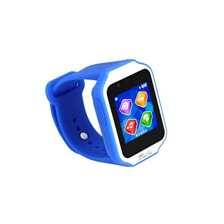


Example 2
Description: Qualatex Foil Balloon 13955 Little Man Bow-tie, 18", Multicolor (ID: 022613ca2afc8d2779b77fba98ab4a46)
Pred price: 12.37083294844801
Actual price: 6.01


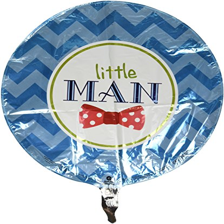


Example 3
Description: Disney "Cars 2" Paint By Numbers, Party Favor (ID: 04b9ad587c23b5bb58cbbefab1c64d34)
Pred price: 26.03745368769284
Actual price: 7.39


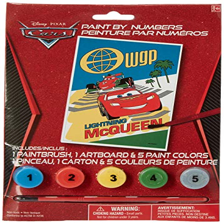

In [57]:
from itertools import islice
import numpy as np
from PIL import Image
import io

# Helper to build a short description from fields
def describe_example(ex):
    name = ex.get("Product Name") or ""
    uid = ex.get("Uniq Id") or ""
    return f"{name} (ID: {uid})".strip()

# Normalize image field to PIL RGB for display/prediction
def to_pil(img_field):
    if isinstance(img_field, dict) and "bytes" in img_field:
        return Image.open(io.BytesIO(img_field["bytes"])).convert("RGB")
    if isinstance(img_field, Image.Image):
        return img_field.convert("RGB")
    raise TypeError(f"Unexpected image type: {type(img_field)}")


def predict_one(ex):
    # Preprocess text and image as in preprocess_example
    text = describe_example(ex)
    price_raw = parse_price(ex.get("Selling Price", None))
    price_raw = price_raw if price_raw is not None else 1e-3
    img = to_pil(ex["image"])

    text_inputs = tokenizer(
        text if text else "",
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="np",
    )
    image_inputs = image_processor(images=img, return_tensors="np", data_format="channels_last")

    inputs = {
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "pixel_values": image_inputs["pixel_values"],
    }
    pred_log = model.predict(inputs, verbose=0).squeeze().item()
    return float(np.exp(pred_log)), float(price_raw), text, img

# Show 3 samples from the raw test stream with prediction vs. actual price
examples = list(islice(test_dataset, 3))
for i, ex in enumerate(examples, 1):
    pred_price, actual_price, desc, img = predict_one(ex)
    print(f"\nExample {i}")
    print("Description:", desc)
    print("Pred price:", pred_price)
    print("Actual price:", actual_price)
    display(img.resize((224, 224)))

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Finetune on small local CSV dataset - Our own dataset on Sloan Buy Sell Whatsapp Group

LOCAL_CSV = "/content/drive/MyDrive/HODL/dataset_final/dataset.csv"
IMAGE_BASE = "/content/drive/MyDrive/HODL/dataset_final/images"
MIN_PRICE = 1.0  # drop records with price <= 0 or extremely small

local_ds = load_dataset("csv", data_files=LOCAL_CSV)["train"]

# Split local dataset (no streaming here)
local_split = local_ds.train_test_split(test_size=0.2, seed=42)
local_train_raw = local_split["train"]
local_val_raw = local_split["test"]

# Filter out rows without image_ref to keep consistency for ViT
def has_image(ex):
    ref = ex.get("image_ref", "")
    return bool(ref)

# Filter out invalid/missing/too-small prices
def has_valid_price(ex):
    try:
        p = float(ex.get("price", "nan"))
    except Exception:
        return False
    return np.isfinite(p) and p >= MIN_PRICE

local_train_raw = local_train_raw.filter(has_image).filter(has_valid_price)
local_val_raw = local_val_raw.filter(has_image).filter(has_valid_price)

print(local_train_raw.shape, local_val_raw.shape)


(51, 3) (14, 3)


In [60]:
# Preprocess the local CSV dataset (description + image_ref + price)

def load_local_image(ref):
    path = os.path.join(IMAGE_BASE, ref)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    return Image.open(path).convert("RGB")


def preprocess_local(ex):
    img = load_local_image(ex["image_ref"])
    text = ex.get("description", "")
    # Enforce minimum price threshold to avoid log spikes from bad data
    price = float(ex.get("price", 1.0))
    price = max(price, MIN_PRICE)
    log_price = float(math.log(price))

    text_inputs = tokenizer(
        text if text else "",
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="np",
    )
    image_inputs = image_processor(images=img, return_tensors="np", data_format="channels_last")

    return {
        "input_ids": text_inputs["input_ids"][0].astype(np.int32),
        "attention_mask": text_inputs["attention_mask"][0].astype(np.int32),
        "pixel_values": image_inputs["pixel_values"][0].astype(np.float32),
        "labels": np.array(log_price, dtype=np.float32),
    }


local_train_proc = local_train_raw.map(preprocess_local)
local_val_proc = local_val_raw.map(preprocess_local)

print(next(iter(local_train_proc)))


{'description': 'Printer', 'image_ref': 'drive_file_1EI-zPCWfMOYlbc9isEaY5OxWs1OKrAfV.pdf_p60_img0_a96a5a', 'price': 80.0, 'input_ids': [101, 15041, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'pixel_values': [[[0.5058823823928833, 0.46666669845581055, 0.3176

In [61]:
# Build tf.data datasets for local finetuning
columns_local = ["input_ids", "attention_mask", "pixel_values"]

def gen_tf_local(ds):
    for ex in ds:
        feats = {k: tf.convert_to_tensor(ex[k]) for k in columns_local}
        lbl = tf.convert_to_tensor(ex["labels"], dtype=tf.float32)
        yield feats, lbl

sig_local = (
    {
        "input_ids": tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32),
        "pixel_values": tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(1,), dtype=tf.float32), # Changed shape from () to (1,) to match generator output
)

train_tf_local = tf.data.Dataset.from_generator(lambda: gen_tf_local(local_train_proc), output_signature=sig_local).batch(2)
val_tf_local = tf.data.Dataset.from_generator(lambda: gen_tf_local(local_val_proc), output_signature=sig_local).batch(2)

for batch in train_tf_local.take(1):
    x, y = batch
    print({k: v.shape for k, v in x.items()}, "labels", y.shape)

{'input_ids': TensorShape([2, 128]), 'attention_mask': TensorShape([2, 128]), 'pixel_values': TensorShape([2, 224, 224, 3])} labels (2, 1)


In [62]:
# Unfreeze encoders and finetune with a low learning rate on the small dataset
for layer in bert_encoder.layers:
    layer.trainable = True
for layer in vit_encoder.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="mse",
    metrics=["mae"],
)

FINETUNE_EPOCHS = 10
history_ft = model.fit(
    train_tf_local,
    validation_data=val_tf_local,
    epochs=FINETUNE_EPOCHS,
)

# Evaluate on the small validation set
ft_eval = model.evaluate(val_tf_local, return_dict=True)
ft_rmse = float(np.sqrt(ft_eval["loss"]))
print({"mse": ft_eval["loss"], "rmse": ft_rmse, "mae_log": ft_eval.get("mae", None)})


Epoch 1/10
26/26 [==============================] - 43s 884ms/step - loss: 1.5470 - mae: 1.0799 - val_loss: 2.8218 - val_mae: 1.4142
Epoch 2/10
26/26 [==============================] - 15s 589ms/step - loss: 1.3832 - mae: 1.0064 - val_loss: 2.4740 - val_mae: 1.3215
Epoch 3/10
26/26 [==============================] - 14s 528ms/step - loss: 1.3203 - mae: 0.9742 - val_loss: 2.2500 - val_mae: 1.2575
Epoch 4/10
26/26 [==============================] - 15s 586ms/step - loss: 1.2380 - mae: 0.9283 - val_loss: 2.1733 - val_mae: 1.2341
Epoch 5/10
26/26 [==============================] - 14s 530ms/step - loss: 1.1306 - mae: 0.8958 - val_loss: 2.1264 - val_mae: 1.2204
Epoch 6/10
26/26 [==============================] - 15s 591ms/step - loss: 1.1883 - mae: 0.8857 - val_loss: 2.0769 - val_mae: 1.2053
Epoch 7/10
26/26 [==============================] - 14s 530ms/step - loss: 1.0079 - mae: 0.8336 - val_loss: 2.0599 - val_mae: 1.1993
Epoch 8/10
26/26 [==============================] - 15s 589ms/step - 